In [35]:
#SOM网络pytorch实现
import numpy as np
c1 = np.array([1,1])
c2 = np.array([-1,-1])
c3 = np.array([1,-1])
c4 = np.array([-1,1])

In [36]:
x1 = c1 + np.random.random_sample([100,2])-1
x2 = c2 + np.random.random_sample([100,2])
x3 = c3 + np.random.random_sample([100,2])-1
x4 = c4 + np.random.random_sample([100,2])-1
x3[:,1] = x3[:,1] + 1
x4[:,0] = x4[:,0] + 1

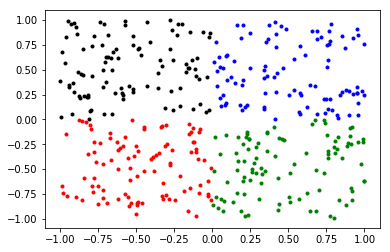

In [37]:
import matplotlib.pyplot as plt
plt.plot(x1[:,0],x1[:,1],'b.')
plt.plot(x2[:,0],x2[:,1],'r.')
plt.plot(x3[:,0],x3[:,1],'g.')
plt.plot(x4[:,0],x4[:,1],'k.')
plt.show()

In [38]:
x = np.concatenate((x1,x2,x3,x4))
label = np.concatenate((np.array([1]*100),np.array([2]*100),np.array([3]*100),np.array([4]*100)))

In [39]:
print(x.shape)
print(label.shape)

(400, 2)
(400,)


In [40]:
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(label)

In [41]:
import torch
import torch.nn as nn
x = torch.FloatTensor(x)
y = torch.tensor(label)
print(x[1])

tensor([ 0.6824, -0.9177])


In [42]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [113]:
class SOM(nn.Module):
    """Model proposed in understanding beta-VAE paper(Burgess et al, arxiv:1804.03599, 2018)."""

    def __init__(self):
        super(SOM, self).__init__()
        self.SOM_layer = nn.Parameter(torch.rand(4,2))
        self.weight_init()

    def weight_init(self):
        for w in self.SOM_layer:
            kaiming_init(w)
    def forward(self, x, y = None):
        distance = [(((x-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in self.SOM_layer]
        distance = torch.cat(distance,dim=-1)
        if y is None:
            _, index = distance.min(dim=1)
        else:
            index = y-1
        mask = Variable(torch.eye(4).index_select(dim=0, index=index.data))

        return mask, index

In [114]:
from torch.utils.data import Dataset, DataLoader
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, label_tensor):
        self.data_tensor = data_tensor
        self.label_tensor = label_tensor

    def __getitem__(self, index):
        return self.data_tensor[index],self.label_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)
def return_data(it):
    return x[10*(it-1):it*10,:],y[10*(it-1):it*10]

In [139]:
from tqdm import tqdm
from torch.autograd import Variable
import torch.optim as optim
net = SOM()

def train():
    optimizer = optim.Adam(net.parameters(), lr=10e-4,
                                    betas=(0.9, 0.99))
    print("training start!!!")
    global_iter = 0
    it = 1
    pbar = tqdm(total=1000)
    pbar.update(global_iter)
    for i in range(1000):
        x_,y = return_data(it)
        pbar.update(1)
        if it == 10:
            it = 1
        else:
            it += 1
        global_iter += 1
        x_ = Variable(x_)
        y = Variable(y)
        mask, index = net(x_)
        cluster_loss = (torch.cat([(((x_-w)**2).sum(-1)).unsqueeze(-1) for w in net.SOM_layer],dim=-1)*mask).sum(1).mean(0)
        optimizer.zero_grad()
        cluster_loss.backward()
        optimizer.step()
        print(cluster_loss)
    pbar.close()

In [140]:
x.shape

torch.Size([400, 2])

In [141]:
train()

training start!!!


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

tensor(0.8764, grad_fn=<MeanBackward0>)
tensor(0.7491, grad_fn=<MeanBackward0>)
tensor(0.4175, grad_fn=<MeanBackward0>)
tensor(0.3171, grad_fn=<MeanBackward0>)
tensor(0.4191, grad_fn=<MeanBackward0>)
tensor(0.6031, grad_fn=<MeanBackward0>)
tensor(0.4637, grad_fn=<MeanBackward0>)
tensor(0.5274, grad_fn=<MeanBackward0>)
tensor(0.6616, grad_fn=<MeanBackward0>)
tensor(0.4106, grad_fn=<MeanBackward0>)
tensor(0.8658, grad_fn=<MeanBackward0>)
tensor(0.7381, grad_fn=<MeanBackward0>)
tensor(0.4090, grad_fn=<MeanBackward0>)
tensor(0.3131, grad_fn=<MeanBackward0>)
tensor(0.4104, grad_fn=<MeanBackward0>)
tensor(0.5975, grad_fn=<MeanBackward0>)
tensor(0.4537, grad_fn=<MeanBackward0>)
tensor(0.5195, grad_fn=<MeanBackward0>)
tensor(0.6524, grad_fn=<MeanBackward0>)
tensor(0.4052, grad_fn=<MeanBackward0>)
tensor(0.8556, grad_fn=<MeanBackward0>)
tensor(0.7274, grad_fn=<MeanBackward0>)
tensor(0.4009, grad_fn=<MeanBackward0>)
tensor(0.3094, grad_fn=<MeanBackward0>)
tensor(0.4020, grad_fn=<MeanBackward0>)


  3%|██▍                                                                            | 31/1000 [00:00<00:06, 142.48it/s]

tensor(0.8457, grad_fn=<MeanBackward0>)
tensor(0.7168, grad_fn=<MeanBackward0>)
tensor(0.3928, grad_fn=<MeanBackward0>)
tensor(0.3059, grad_fn=<MeanBackward0>)
tensor(0.3936, grad_fn=<MeanBackward0>)
tensor(0.5853, grad_fn=<MeanBackward0>)
tensor(0.4342, grad_fn=<MeanBackward0>)
tensor(0.5043, grad_fn=<MeanBackward0>)
tensor(0.6344, grad_fn=<MeanBackward0>)
tensor(0.3947, grad_fn=<MeanBackward0>)
tensor(0.8362, grad_fn=<MeanBackward0>)
tensor(0.7064, grad_fn=<MeanBackward0>)
tensor(0.3848, grad_fn=<MeanBackward0>)
tensor(0.3026, grad_fn=<MeanBackward0>)
tensor(0.3855, grad_fn=<MeanBackward0>)
tensor(0.5790, grad_fn=<MeanBackward0>)
tensor(0.4247, grad_fn=<MeanBackward0>)
tensor(0.4971, grad_fn=<MeanBackward0>)
tensor(0.6258, grad_fn=<MeanBackward0>)
tensor(0.3897, grad_fn=<MeanBackward0>)
tensor(0.8268, grad_fn=<MeanBackward0>)
tensor(0.6963, grad_fn=<MeanBackward0>)
tensor(0.3771, grad_fn=<MeanBackward0>)
tensor(0.2994, grad_fn=<MeanBackward0>)
tensor(0.3776, grad_fn=<MeanBackward0>)


  6%|████▉                                                                          | 62/1000 [00:00<00:05, 169.97it/s]

tensor(0.6864, grad_fn=<MeanBackward0>)
tensor(0.3695, grad_fn=<MeanBackward0>)
tensor(0.2965, grad_fn=<MeanBackward0>)
tensor(0.3700, grad_fn=<MeanBackward0>)
tensor(0.5668, grad_fn=<MeanBackward0>)
tensor(0.4049, grad_fn=<MeanBackward0>)
tensor(0.4835, grad_fn=<MeanBackward0>)
tensor(0.6092, grad_fn=<MeanBackward0>)
tensor(0.3799, grad_fn=<MeanBackward0>)
tensor(0.8090, grad_fn=<MeanBackward0>)
tensor(0.6770, grad_fn=<MeanBackward0>)
tensor(0.3620, grad_fn=<MeanBackward0>)
tensor(0.2938, grad_fn=<MeanBackward0>)
tensor(0.3626, grad_fn=<MeanBackward0>)
tensor(0.5609, grad_fn=<MeanBackward0>)
tensor(0.3954, grad_fn=<MeanBackward0>)
tensor(0.4770, grad_fn=<MeanBackward0>)
tensor(0.6013, grad_fn=<MeanBackward0>)
tensor(0.3743, grad_fn=<MeanBackward0>)
tensor(0.8003, grad_fn=<MeanBackward0>)
tensor(0.6679, grad_fn=<MeanBackward0>)
tensor(0.3546, grad_fn=<MeanBackward0>)
tensor(0.2912, grad_fn=<MeanBackward0>)
tensor(0.3553, grad_fn=<MeanBackward0>)
tensor(0.5551, grad_fn=<MeanBackward0>)


  9%|██████▉                                                                        | 88/1000 [00:00<00:04, 186.50it/s]

tensor(0.4706, grad_fn=<MeanBackward0>)
tensor(0.5930, grad_fn=<MeanBackward0>)
tensor(0.3689, grad_fn=<MeanBackward0>)
tensor(0.7918, grad_fn=<MeanBackward0>)
tensor(0.6592, grad_fn=<MeanBackward0>)
tensor(0.3472, grad_fn=<MeanBackward0>)
tensor(0.2888, grad_fn=<MeanBackward0>)
tensor(0.3483, grad_fn=<MeanBackward0>)
tensor(0.5494, grad_fn=<MeanBackward0>)
tensor(0.3780, grad_fn=<MeanBackward0>)
tensor(0.4645, grad_fn=<MeanBackward0>)
tensor(0.5843, grad_fn=<MeanBackward0>)
tensor(0.3633, grad_fn=<MeanBackward0>)
tensor(0.7834, grad_fn=<MeanBackward0>)
tensor(0.6509, grad_fn=<MeanBackward0>)
tensor(0.3400, grad_fn=<MeanBackward0>)


 10%|████████                                                                      | 104/1000 [00:00<00:05, 164.35it/s]

tensor(0.2865, grad_fn=<MeanBackward0>)
tensor(0.3415, grad_fn=<MeanBackward0>)
tensor(0.5438, grad_fn=<MeanBackward0>)
tensor(0.3699, grad_fn=<MeanBackward0>)
tensor(0.4586, grad_fn=<MeanBackward0>)
tensor(0.5759, grad_fn=<MeanBackward0>)
tensor(0.3580, grad_fn=<MeanBackward0>)
tensor(0.7752, grad_fn=<MeanBackward0>)
tensor(0.6429, grad_fn=<MeanBackward0>)
tensor(0.3330, grad_fn=<MeanBackward0>)
tensor(0.2834, grad_fn=<MeanBackward0>)
tensor(0.3349, grad_fn=<MeanBackward0>)
tensor(0.5384, grad_fn=<MeanBackward0>)
tensor(0.3623, grad_fn=<MeanBackward0>)
tensor(0.4528, grad_fn=<MeanBackward0>)
tensor(0.5676, grad_fn=<MeanBackward0>)
tensor(0.3525, grad_fn=<MeanBackward0>)
tensor(0.7671, grad_fn=<MeanBackward0>)
tensor(0.6353, grad_fn=<MeanBackward0>)
tensor(0.3261, grad_fn=<MeanBackward0>)
tensor(0.2801, grad_fn=<MeanBackward0>)
tensor(0.3284, grad_fn=<MeanBackward0>)
tensor(0.5331, grad_fn=<MeanBackward0>)
tensor(0.3551, grad_fn=<MeanBackward0>)
tensor(0.4472, grad_fn=<MeanBackward0>)


 13%|██████████▎                                                                   | 132/1000 [00:00<00:04, 186.18it/s]

tensor(0.6279, grad_fn=<MeanBackward0>)
tensor(0.3193, grad_fn=<MeanBackward0>)
tensor(0.2770, grad_fn=<MeanBackward0>)
tensor(0.3221, grad_fn=<MeanBackward0>)
tensor(0.5280, grad_fn=<MeanBackward0>)
tensor(0.3483, grad_fn=<MeanBackward0>)
tensor(0.4418, grad_fn=<MeanBackward0>)
tensor(0.5515, grad_fn=<MeanBackward0>)
tensor(0.3390, grad_fn=<MeanBackward0>)
tensor(0.7512, grad_fn=<MeanBackward0>)
tensor(0.6209, grad_fn=<MeanBackward0>)
tensor(0.3128, grad_fn=<MeanBackward0>)
tensor(0.2740, grad_fn=<MeanBackward0>)
tensor(0.3161, grad_fn=<MeanBackward0>)
tensor(0.5229, grad_fn=<MeanBackward0>)
tensor(0.3418, grad_fn=<MeanBackward0>)
tensor(0.4365, grad_fn=<MeanBackward0>)
tensor(0.5439, grad_fn=<MeanBackward0>)
tensor(0.3326, grad_fn=<MeanBackward0>)
tensor(0.7436, grad_fn=<MeanBackward0>)
tensor(0.6140, grad_fn=<MeanBackward0>)
tensor(0.3066, grad_fn=<MeanBackward0>)
tensor(0.2712, grad_fn=<MeanBackward0>)
tensor(0.3102, grad_fn=<MeanBackward0>)
tensor(0.5181, grad_fn=<MeanBackward0>)


 17%|█████████████                                                                 | 168/1000 [00:00<00:03, 217.02it/s]

tensor(0.4261, grad_fn=<MeanBackward0>)
tensor(0.5289, grad_fn=<MeanBackward0>)
tensor(0.3209, grad_fn=<MeanBackward0>)
tensor(0.7289, grad_fn=<MeanBackward0>)
tensor(0.6010, grad_fn=<MeanBackward0>)
tensor(0.2949, grad_fn=<MeanBackward0>)
tensor(0.2661, grad_fn=<MeanBackward0>)
tensor(0.2990, grad_fn=<MeanBackward0>)
tensor(0.5084, grad_fn=<MeanBackward0>)
tensor(0.3237, grad_fn=<MeanBackward0>)
tensor(0.4206, grad_fn=<MeanBackward0>)
tensor(0.5205, grad_fn=<MeanBackward0>)
tensor(0.3152, grad_fn=<MeanBackward0>)
tensor(0.7219, grad_fn=<MeanBackward0>)
tensor(0.5947, grad_fn=<MeanBackward0>)
tensor(0.2891, grad_fn=<MeanBackward0>)
tensor(0.2636, grad_fn=<MeanBackward0>)
tensor(0.2937, grad_fn=<MeanBackward0>)
tensor(0.5033, grad_fn=<MeanBackward0>)
tensor(0.3178, grad_fn=<MeanBackward0>)
tensor(0.4152, grad_fn=<MeanBackward0>)
tensor(0.5124, grad_fn=<MeanBackward0>)
tensor(0.3098, grad_fn=<MeanBackward0>)
tensor(0.7148, grad_fn=<MeanBackward0>)
tensor(0.5886, grad_fn=<MeanBackward0>)


 20%|███████████████▍                                                              | 198/1000 [00:00<00:03, 234.84it/s]

tensor(0.4100, grad_fn=<MeanBackward0>)
tensor(0.5044, grad_fn=<MeanBackward0>)
tensor(0.3044, grad_fn=<MeanBackward0>)
tensor(0.7066, grad_fn=<MeanBackward0>)
tensor(0.5827, grad_fn=<MeanBackward0>)
tensor(0.2781, grad_fn=<MeanBackward0>)
tensor(0.2592, grad_fn=<MeanBackward0>)
tensor(0.2835, grad_fn=<MeanBackward0>)
tensor(0.4935, grad_fn=<MeanBackward0>)
tensor(0.3070, grad_fn=<MeanBackward0>)
tensor(0.4050, grad_fn=<MeanBackward0>)
tensor(0.4965, grad_fn=<MeanBackward0>)
tensor(0.2992, grad_fn=<MeanBackward0>)
tensor(0.6985, grad_fn=<MeanBackward0>)
tensor(0.5771, grad_fn=<MeanBackward0>)
tensor(0.2729, grad_fn=<MeanBackward0>)
tensor(0.2571, grad_fn=<MeanBackward0>)
tensor(0.2786, grad_fn=<MeanBackward0>)
tensor(0.4889, grad_fn=<MeanBackward0>)
tensor(0.3020, grad_fn=<MeanBackward0>)
tensor(0.4002, grad_fn=<MeanBackward0>)
tensor(0.4890, grad_fn=<MeanBackward0>)
tensor(0.2942, grad_fn=<MeanBackward0>)
tensor(0.6904, grad_fn=<MeanBackward0>)
tensor(0.5716, grad_fn=<MeanBackward0>)


 23%|█████████████████▋                                                            | 226/1000 [00:00<00:03, 246.61it/s]

tensor(0.4844, grad_fn=<MeanBackward0>)
tensor(0.2970, grad_fn=<MeanBackward0>)
tensor(0.3955, grad_fn=<MeanBackward0>)
tensor(0.4816, grad_fn=<MeanBackward0>)
tensor(0.2895, grad_fn=<MeanBackward0>)
tensor(0.6824, grad_fn=<MeanBackward0>)
tensor(0.5663, grad_fn=<MeanBackward0>)
tensor(0.2631, grad_fn=<MeanBackward0>)
tensor(0.2536, grad_fn=<MeanBackward0>)
tensor(0.2694, grad_fn=<MeanBackward0>)
tensor(0.4800, grad_fn=<MeanBackward0>)
tensor(0.2921, grad_fn=<MeanBackward0>)
tensor(0.3909, grad_fn=<MeanBackward0>)
tensor(0.4745, grad_fn=<MeanBackward0>)
tensor(0.2851, grad_fn=<MeanBackward0>)
tensor(0.6746, grad_fn=<MeanBackward0>)
tensor(0.5610, grad_fn=<MeanBackward0>)
tensor(0.2584, grad_fn=<MeanBackward0>)
tensor(0.2522, grad_fn=<MeanBackward0>)
tensor(0.2651, grad_fn=<MeanBackward0>)
tensor(0.4755, grad_fn=<MeanBackward0>)
tensor(0.2871, grad_fn=<MeanBackward0>)
tensor(0.3857, grad_fn=<MeanBackward0>)
tensor(0.4677, grad_fn=<MeanBackward0>)
tensor(0.2810, grad_fn=<MeanBackward0>)


 26%|████████████████████                                                          | 257/1000 [00:01<00:02, 261.55it/s]

tensor(0.2822, grad_fn=<MeanBackward0>)
tensor(0.3807, grad_fn=<MeanBackward0>)
tensor(0.4611, grad_fn=<MeanBackward0>)
tensor(0.2769, grad_fn=<MeanBackward0>)
tensor(0.6598, grad_fn=<MeanBackward0>)
tensor(0.5509, grad_fn=<MeanBackward0>)
tensor(0.2493, grad_fn=<MeanBackward0>)
tensor(0.2497, grad_fn=<MeanBackward0>)
tensor(0.2569, grad_fn=<MeanBackward0>)
tensor(0.4666, grad_fn=<MeanBackward0>)
tensor(0.2774, grad_fn=<MeanBackward0>)
tensor(0.3758, grad_fn=<MeanBackward0>)
tensor(0.4548, grad_fn=<MeanBackward0>)
tensor(0.2731, grad_fn=<MeanBackward0>)
tensor(0.6527, grad_fn=<MeanBackward0>)
tensor(0.5461, grad_fn=<MeanBackward0>)
tensor(0.2449, grad_fn=<MeanBackward0>)
tensor(0.2487, grad_fn=<MeanBackward0>)
tensor(0.2530, grad_fn=<MeanBackward0>)
tensor(0.4624, grad_fn=<MeanBackward0>)
tensor(0.2728, grad_fn=<MeanBackward0>)
tensor(0.3711, grad_fn=<MeanBackward0>)
tensor(0.4487, grad_fn=<MeanBackward0>)
tensor(0.2694, grad_fn=<MeanBackward0>)
tensor(0.6459, grad_fn=<MeanBackward0>)


 29%|██████████████████████▍                                                       | 288/1000 [00:01<00:02, 273.49it/s]

tensor(0.3666, grad_fn=<MeanBackward0>)
tensor(0.4428, grad_fn=<MeanBackward0>)
tensor(0.2660, grad_fn=<MeanBackward0>)
tensor(0.6392, grad_fn=<MeanBackward0>)
tensor(0.5359, grad_fn=<MeanBackward0>)
tensor(0.2368, grad_fn=<MeanBackward0>)
tensor(0.2471, grad_fn=<MeanBackward0>)
tensor(0.2457, grad_fn=<MeanBackward0>)
tensor(0.4541, grad_fn=<MeanBackward0>)
tensor(0.2638, grad_fn=<MeanBackward0>)
tensor(0.3621, grad_fn=<MeanBackward0>)
tensor(0.4370, grad_fn=<MeanBackward0>)
tensor(0.2629, grad_fn=<MeanBackward0>)
tensor(0.6322, grad_fn=<MeanBackward0>)
tensor(0.5308, grad_fn=<MeanBackward0>)
tensor(0.2329, grad_fn=<MeanBackward0>)
tensor(0.2464, grad_fn=<MeanBackward0>)
tensor(0.2422, grad_fn=<MeanBackward0>)
tensor(0.4502, grad_fn=<MeanBackward0>)
tensor(0.2597, grad_fn=<MeanBackward0>)
tensor(0.3578, grad_fn=<MeanBackward0>)
tensor(0.4312, grad_fn=<MeanBackward0>)
tensor(0.2596, grad_fn=<MeanBackward0>)
tensor(0.6243, grad_fn=<MeanBackward0>)
tensor(0.5261, grad_fn=<MeanBackward0>)


 32%|████████████████████████▋                                                     | 317/1000 [00:01<00:02, 272.92it/s]

tensor(0.2560, grad_fn=<MeanBackward0>)
tensor(0.3537, grad_fn=<MeanBackward0>)
tensor(0.4255, grad_fn=<MeanBackward0>)
tensor(0.2563, grad_fn=<MeanBackward0>)
tensor(0.6164, grad_fn=<MeanBackward0>)
tensor(0.5216, grad_fn=<MeanBackward0>)
tensor(0.2256, grad_fn=<MeanBackward0>)
tensor(0.2453, grad_fn=<MeanBackward0>)
tensor(0.2357, grad_fn=<MeanBackward0>)
tensor(0.4428, grad_fn=<MeanBackward0>)
tensor(0.2524, grad_fn=<MeanBackward0>)
tensor(0.3497, grad_fn=<MeanBackward0>)
tensor(0.4199, grad_fn=<MeanBackward0>)
tensor(0.2533, grad_fn=<MeanBackward0>)
tensor(0.6087, grad_fn=<MeanBackward0>)
tensor(0.5172, grad_fn=<MeanBackward0>)
tensor(0.2221, grad_fn=<MeanBackward0>)
tensor(0.2449, grad_fn=<MeanBackward0>)
tensor(0.2326, grad_fn=<MeanBackward0>)
tensor(0.4393, grad_fn=<MeanBackward0>)
tensor(0.2489, grad_fn=<MeanBackward0>)
tensor(0.3459, grad_fn=<MeanBackward0>)
tensor(0.4146, grad_fn=<MeanBackward0>)
tensor(0.2504, grad_fn=<MeanBackward0>)
tensor(0.6012, grad_fn=<MeanBackward0>)


 35%|███████████████████████████                                                   | 347/1000 [00:01<00:02, 279.13it/s]

tensor(0.2457, grad_fn=<MeanBackward0>)
tensor(0.3423, grad_fn=<MeanBackward0>)
tensor(0.4094, grad_fn=<MeanBackward0>)
tensor(0.2476, grad_fn=<MeanBackward0>)
tensor(0.5939, grad_fn=<MeanBackward0>)
tensor(0.5090, grad_fn=<MeanBackward0>)
tensor(0.2156, grad_fn=<MeanBackward0>)
tensor(0.2444, grad_fn=<MeanBackward0>)
tensor(0.2268, grad_fn=<MeanBackward0>)
tensor(0.4327, grad_fn=<MeanBackward0>)
tensor(0.2425, grad_fn=<MeanBackward0>)
tensor(0.3388, grad_fn=<MeanBackward0>)
tensor(0.4044, grad_fn=<MeanBackward0>)
tensor(0.2451, grad_fn=<MeanBackward0>)
tensor(0.5869, grad_fn=<MeanBackward0>)
tensor(0.5052, grad_fn=<MeanBackward0>)
tensor(0.2126, grad_fn=<MeanBackward0>)
tensor(0.2444, grad_fn=<MeanBackward0>)
tensor(0.2241, grad_fn=<MeanBackward0>)
tensor(0.4295, grad_fn=<MeanBackward0>)
tensor(0.2395, grad_fn=<MeanBackward0>)
tensor(0.3355, grad_fn=<MeanBackward0>)
tensor(0.3995, grad_fn=<MeanBackward0>)
tensor(0.2427, grad_fn=<MeanBackward0>)
tensor(0.5801, grad_fn=<MeanBackward0>)


 38%|█████████████████████████████▍                                                | 377/1000 [00:01<00:02, 280.85it/s]

tensor(0.2366, grad_fn=<MeanBackward0>)
tensor(0.3323, grad_fn=<MeanBackward0>)
tensor(0.3949, grad_fn=<MeanBackward0>)
tensor(0.2405, grad_fn=<MeanBackward0>)
tensor(0.5735, grad_fn=<MeanBackward0>)
tensor(0.4979, grad_fn=<MeanBackward0>)
tensor(0.2070, grad_fn=<MeanBackward0>)
tensor(0.2445, grad_fn=<MeanBackward0>)
tensor(0.2191, grad_fn=<MeanBackward0>)
tensor(0.4235, grad_fn=<MeanBackward0>)
tensor(0.2338, grad_fn=<MeanBackward0>)
tensor(0.3292, grad_fn=<MeanBackward0>)
tensor(0.3903, grad_fn=<MeanBackward0>)
tensor(0.2384, grad_fn=<MeanBackward0>)
tensor(0.5670, grad_fn=<MeanBackward0>)
tensor(0.4944, grad_fn=<MeanBackward0>)
tensor(0.2044, grad_fn=<MeanBackward0>)
tensor(0.2447, grad_fn=<MeanBackward0>)
tensor(0.2168, grad_fn=<MeanBackward0>)
tensor(0.4207, grad_fn=<MeanBackward0>)
tensor(0.2312, grad_fn=<MeanBackward0>)
tensor(0.3262, grad_fn=<MeanBackward0>)
tensor(0.3860, grad_fn=<MeanBackward0>)
tensor(0.2364, grad_fn=<MeanBackward0>)
tensor(0.5606, grad_fn=<MeanBackward0>)


 41%|███████████████████████████████▋                                              | 406/1000 [00:01<00:02, 279.21it/s]

tensor(0.4178, grad_fn=<MeanBackward0>)
tensor(0.2285, grad_fn=<MeanBackward0>)
tensor(0.3233, grad_fn=<MeanBackward0>)
tensor(0.3818, grad_fn=<MeanBackward0>)
tensor(0.2346, grad_fn=<MeanBackward0>)
tensor(0.5540, grad_fn=<MeanBackward0>)
tensor(0.4877, grad_fn=<MeanBackward0>)
tensor(0.1995, grad_fn=<MeanBackward0>)
tensor(0.2456, grad_fn=<MeanBackward0>)
tensor(0.2124, grad_fn=<MeanBackward0>)
tensor(0.4149, grad_fn=<MeanBackward0>)
tensor(0.2256, grad_fn=<MeanBackward0>)
tensor(0.3203, grad_fn=<MeanBackward0>)
tensor(0.3778, grad_fn=<MeanBackward0>)
tensor(0.2332, grad_fn=<MeanBackward0>)
tensor(0.5465, grad_fn=<MeanBackward0>)
tensor(0.4841, grad_fn=<MeanBackward0>)
tensor(0.1972, grad_fn=<MeanBackward0>)
tensor(0.2463, grad_fn=<MeanBackward0>)
tensor(0.2098, grad_fn=<MeanBackward0>)
tensor(0.4120, grad_fn=<MeanBackward0>)
tensor(0.2226, grad_fn=<MeanBackward0>)
tensor(0.3173, grad_fn=<MeanBackward0>)
tensor(0.3740, grad_fn=<MeanBackward0>)
tensor(0.2320, grad_fn=<MeanBackward0>)


 44%|█████████████████████████████████▉                                            | 435/1000 [00:01<00:02, 279.69it/s]

tensor(0.2074, grad_fn=<MeanBackward0>)
tensor(0.4092, grad_fn=<MeanBackward0>)
tensor(0.2197, grad_fn=<MeanBackward0>)
tensor(0.3143, grad_fn=<MeanBackward0>)
tensor(0.3703, grad_fn=<MeanBackward0>)
tensor(0.2307, grad_fn=<MeanBackward0>)
tensor(0.5321, grad_fn=<MeanBackward0>)
tensor(0.4772, grad_fn=<MeanBackward0>)
tensor(0.1929, grad_fn=<MeanBackward0>)
tensor(0.2481, grad_fn=<MeanBackward0>)
tensor(0.2051, grad_fn=<MeanBackward0>)
tensor(0.4066, grad_fn=<MeanBackward0>)
tensor(0.2168, grad_fn=<MeanBackward0>)
tensor(0.3115, grad_fn=<MeanBackward0>)
tensor(0.3667, grad_fn=<MeanBackward0>)
tensor(0.2287, grad_fn=<MeanBackward0>)
tensor(0.5252, grad_fn=<MeanBackward0>)
tensor(0.4739, grad_fn=<MeanBackward0>)
tensor(0.1910, grad_fn=<MeanBackward0>)
tensor(0.2491, grad_fn=<MeanBackward0>)
tensor(0.2029, grad_fn=<MeanBackward0>)
tensor(0.4040, grad_fn=<MeanBackward0>)
tensor(0.2141, grad_fn=<MeanBackward0>)
tensor(0.3087, grad_fn=<MeanBackward0>)
tensor(0.3632, grad_fn=<MeanBackward0>)


 46%|████████████████████████████████████▏                                         | 464/1000 [00:01<00:01, 282.07it/s]

tensor(0.2503, grad_fn=<MeanBackward0>)
tensor(0.2008, grad_fn=<MeanBackward0>)
tensor(0.4015, grad_fn=<MeanBackward0>)
tensor(0.2114, grad_fn=<MeanBackward0>)
tensor(0.3061, grad_fn=<MeanBackward0>)
tensor(0.3600, grad_fn=<MeanBackward0>)
tensor(0.2250, grad_fn=<MeanBackward0>)
tensor(0.5105, grad_fn=<MeanBackward0>)
tensor(0.4675, grad_fn=<MeanBackward0>)
tensor(0.1875, grad_fn=<MeanBackward0>)
tensor(0.2515, grad_fn=<MeanBackward0>)
tensor(0.1989, grad_fn=<MeanBackward0>)
tensor(0.3991, grad_fn=<MeanBackward0>)
tensor(0.2087, grad_fn=<MeanBackward0>)
tensor(0.3035, grad_fn=<MeanBackward0>)
tensor(0.3569, grad_fn=<MeanBackward0>)
tensor(0.2235, grad_fn=<MeanBackward0>)
tensor(0.5030, grad_fn=<MeanBackward0>)
tensor(0.4640, grad_fn=<MeanBackward0>)
tensor(0.1859, grad_fn=<MeanBackward0>)
tensor(0.2528, grad_fn=<MeanBackward0>)
tensor(0.1971, grad_fn=<MeanBackward0>)
tensor(0.3963, grad_fn=<MeanBackward0>)
tensor(0.2062, grad_fn=<MeanBackward0>)
tensor(0.3010, grad_fn=<MeanBackward0>)


 49%|██████████████████████████████████████▍                                       | 493/1000 [00:01<00:01, 282.51it/s]

tensor(0.1843, grad_fn=<MeanBackward0>)
tensor(0.2531, grad_fn=<MeanBackward0>)
tensor(0.1953, grad_fn=<MeanBackward0>)
tensor(0.3929, grad_fn=<MeanBackward0>)
tensor(0.2038, grad_fn=<MeanBackward0>)
tensor(0.2985, grad_fn=<MeanBackward0>)
tensor(0.3508, grad_fn=<MeanBackward0>)
tensor(0.2204, grad_fn=<MeanBackward0>)
tensor(0.4871, grad_fn=<MeanBackward0>)
tensor(0.4566, grad_fn=<MeanBackward0>)
tensor(0.1828, grad_fn=<MeanBackward0>)
tensor(0.2529, grad_fn=<MeanBackward0>)
tensor(0.1937, grad_fn=<MeanBackward0>)
tensor(0.3897, grad_fn=<MeanBackward0>)
tensor(0.2016, grad_fn=<MeanBackward0>)
tensor(0.2961, grad_fn=<MeanBackward0>)
tensor(0.3477, grad_fn=<MeanBackward0>)
tensor(0.2188, grad_fn=<MeanBackward0>)
tensor(0.4792, grad_fn=<MeanBackward0>)
tensor(0.4530, grad_fn=<MeanBackward0>)
tensor(0.1814, grad_fn=<MeanBackward0>)
tensor(0.2529, grad_fn=<MeanBackward0>)
tensor(0.1921, grad_fn=<MeanBackward0>)
tensor(0.3868, grad_fn=<MeanBackward0>)
tensor(0.1996, grad_fn=<MeanBackward0>)


 52%|████████████████████████████████████████▊                                     | 523/1000 [00:01<00:01, 283.24it/s]

tensor(0.1801, grad_fn=<MeanBackward0>)
tensor(0.2529, grad_fn=<MeanBackward0>)
tensor(0.1907, grad_fn=<MeanBackward0>)
tensor(0.3841, grad_fn=<MeanBackward0>)
tensor(0.1976, grad_fn=<MeanBackward0>)
tensor(0.2916, grad_fn=<MeanBackward0>)
tensor(0.3420, grad_fn=<MeanBackward0>)
tensor(0.2160, grad_fn=<MeanBackward0>)
tensor(0.4644, grad_fn=<MeanBackward0>)
tensor(0.4462, grad_fn=<MeanBackward0>)
tensor(0.1789, grad_fn=<MeanBackward0>)
tensor(0.2528, grad_fn=<MeanBackward0>)
tensor(0.1894, grad_fn=<MeanBackward0>)
tensor(0.3816, grad_fn=<MeanBackward0>)
tensor(0.1958, grad_fn=<MeanBackward0>)
tensor(0.2888, grad_fn=<MeanBackward0>)
tensor(0.3392, grad_fn=<MeanBackward0>)
tensor(0.2145, grad_fn=<MeanBackward0>)
tensor(0.4574, grad_fn=<MeanBackward0>)
tensor(0.4429, grad_fn=<MeanBackward0>)
tensor(0.1779, grad_fn=<MeanBackward0>)
tensor(0.2521, grad_fn=<MeanBackward0>)
tensor(0.1883, grad_fn=<MeanBackward0>)
tensor(0.3791, grad_fn=<MeanBackward0>)
tensor(0.1942, grad_fn=<MeanBackward0>)


 56%|███████████████████████████████████████████▎                                  | 555/1000 [00:02<00:01, 292.33it/s]

tensor(0.1873, grad_fn=<MeanBackward0>)
tensor(0.3766, grad_fn=<MeanBackward0>)
tensor(0.1926, grad_fn=<MeanBackward0>)
tensor(0.2821, grad_fn=<MeanBackward0>)
tensor(0.3341, grad_fn=<MeanBackward0>)
tensor(0.2111, grad_fn=<MeanBackward0>)
tensor(0.4436, grad_fn=<MeanBackward0>)
tensor(0.4368, grad_fn=<MeanBackward0>)
tensor(0.1761, grad_fn=<MeanBackward0>)
tensor(0.2496, grad_fn=<MeanBackward0>)
tensor(0.1864, grad_fn=<MeanBackward0>)
tensor(0.3741, grad_fn=<MeanBackward0>)
tensor(0.1909, grad_fn=<MeanBackward0>)
tensor(0.2788, grad_fn=<MeanBackward0>)
tensor(0.3318, grad_fn=<MeanBackward0>)
tensor(0.2096, grad_fn=<MeanBackward0>)
tensor(0.4368, grad_fn=<MeanBackward0>)
tensor(0.4340, grad_fn=<MeanBackward0>)
tensor(0.1754, grad_fn=<MeanBackward0>)
tensor(0.2484, grad_fn=<MeanBackward0>)
tensor(0.1856, grad_fn=<MeanBackward0>)
tensor(0.3716, grad_fn=<MeanBackward0>)
tensor(0.1893, grad_fn=<MeanBackward0>)
tensor(0.2757, grad_fn=<MeanBackward0>)
tensor(0.3296, grad_fn=<MeanBackward0>)


 58%|█████████████████████████████████████████████▋                                | 585/1000 [00:02<00:01, 291.78it/s]

tensor(0.1849, grad_fn=<MeanBackward0>)
tensor(0.3692, grad_fn=<MeanBackward0>)
tensor(0.1877, grad_fn=<MeanBackward0>)
tensor(0.2727, grad_fn=<MeanBackward0>)
tensor(0.3276, grad_fn=<MeanBackward0>)
tensor(0.2072, grad_fn=<MeanBackward0>)
tensor(0.4238, grad_fn=<MeanBackward0>)
tensor(0.4285, grad_fn=<MeanBackward0>)
tensor(0.1743, grad_fn=<MeanBackward0>)
tensor(0.2447, grad_fn=<MeanBackward0>)
tensor(0.1843, grad_fn=<MeanBackward0>)
tensor(0.3667, grad_fn=<MeanBackward0>)
tensor(0.1860, grad_fn=<MeanBackward0>)
tensor(0.2698, grad_fn=<MeanBackward0>)
tensor(0.3257, grad_fn=<MeanBackward0>)
tensor(0.2063, grad_fn=<MeanBackward0>)
tensor(0.4175, grad_fn=<MeanBackward0>)
tensor(0.4260, grad_fn=<MeanBackward0>)
tensor(0.1738, grad_fn=<MeanBackward0>)
tensor(0.2428, grad_fn=<MeanBackward0>)
tensor(0.1838, grad_fn=<MeanBackward0>)
tensor(0.3644, grad_fn=<MeanBackward0>)
tensor(0.1844, grad_fn=<MeanBackward0>)
tensor(0.2670, grad_fn=<MeanBackward0>)
tensor(0.3240, grad_fn=<MeanBackward0>)


 62%|████████████████████████████████████████████████▎                             | 619/1000 [00:02<00:01, 304.53it/s]

tensor(0.3218, grad_fn=<MeanBackward0>)
tensor(0.2050, grad_fn=<MeanBackward0>)
tensor(0.4055, grad_fn=<MeanBackward0>)
tensor(0.4212, grad_fn=<MeanBackward0>)
tensor(0.1732, grad_fn=<MeanBackward0>)
tensor(0.2392, grad_fn=<MeanBackward0>)
tensor(0.1829, grad_fn=<MeanBackward0>)
tensor(0.3599, grad_fn=<MeanBackward0>)
tensor(0.1812, grad_fn=<MeanBackward0>)
tensor(0.2617, grad_fn=<MeanBackward0>)
tensor(0.3186, grad_fn=<MeanBackward0>)
tensor(0.2045, grad_fn=<MeanBackward0>)
tensor(0.3996, grad_fn=<MeanBackward0>)
tensor(0.4187, grad_fn=<MeanBackward0>)
tensor(0.1732, grad_fn=<MeanBackward0>)
tensor(0.2373, grad_fn=<MeanBackward0>)
tensor(0.1826, grad_fn=<MeanBackward0>)
tensor(0.3579, grad_fn=<MeanBackward0>)
tensor(0.1794, grad_fn=<MeanBackward0>)
tensor(0.2591, grad_fn=<MeanBackward0>)
tensor(0.3154, grad_fn=<MeanBackward0>)
tensor(0.2034, grad_fn=<MeanBackward0>)
tensor(0.3937, grad_fn=<MeanBackward0>)
tensor(0.4164, grad_fn=<MeanBackward0>)
tensor(0.1733, grad_fn=<MeanBackward0>)


 65%|██████████████████████████████████████████████████▋                           | 650/1000 [00:02<00:01, 300.99it/s]

tensor(0.2023, grad_fn=<MeanBackward0>)
tensor(0.3880, grad_fn=<MeanBackward0>)
tensor(0.4141, grad_fn=<MeanBackward0>)
tensor(0.1735, grad_fn=<MeanBackward0>)
tensor(0.2339, grad_fn=<MeanBackward0>)
tensor(0.1821, grad_fn=<MeanBackward0>)
tensor(0.3541, grad_fn=<MeanBackward0>)
tensor(0.1763, grad_fn=<MeanBackward0>)
tensor(0.2540, grad_fn=<MeanBackward0>)
tensor(0.3093, grad_fn=<MeanBackward0>)
tensor(0.2013, grad_fn=<MeanBackward0>)
tensor(0.3825, grad_fn=<MeanBackward0>)
tensor(0.4119, grad_fn=<MeanBackward0>)
tensor(0.1730, grad_fn=<MeanBackward0>)
tensor(0.2324, grad_fn=<MeanBackward0>)
tensor(0.1820, grad_fn=<MeanBackward0>)
tensor(0.3523, grad_fn=<MeanBackward0>)
tensor(0.1748, grad_fn=<MeanBackward0>)
tensor(0.2517, grad_fn=<MeanBackward0>)
tensor(0.3064, grad_fn=<MeanBackward0>)
tensor(0.2005, grad_fn=<MeanBackward0>)
tensor(0.3771, grad_fn=<MeanBackward0>)
tensor(0.4098, grad_fn=<MeanBackward0>)
tensor(0.1717, grad_fn=<MeanBackward0>)
tensor(0.2308, grad_fn=<MeanBackward0>)


 68%|█████████████████████████████████████████████████████                         | 681/1000 [00:02<00:01, 293.89it/s]

tensor(0.3717, grad_fn=<MeanBackward0>)
tensor(0.4068, grad_fn=<MeanBackward0>)
tensor(0.1705, grad_fn=<MeanBackward0>)
tensor(0.2292, grad_fn=<MeanBackward0>)
tensor(0.1821, grad_fn=<MeanBackward0>)
tensor(0.3490, grad_fn=<MeanBackward0>)
tensor(0.1712, grad_fn=<MeanBackward0>)
tensor(0.2469, grad_fn=<MeanBackward0>)
tensor(0.3007, grad_fn=<MeanBackward0>)
tensor(0.1989, grad_fn=<MeanBackward0>)
tensor(0.3662, grad_fn=<MeanBackward0>)
tensor(0.4035, grad_fn=<MeanBackward0>)
tensor(0.1692, grad_fn=<MeanBackward0>)
tensor(0.2274, grad_fn=<MeanBackward0>)
tensor(0.1823, grad_fn=<MeanBackward0>)
tensor(0.3473, grad_fn=<MeanBackward0>)
tensor(0.1687, grad_fn=<MeanBackward0>)
tensor(0.2445, grad_fn=<MeanBackward0>)
tensor(0.2980, grad_fn=<MeanBackward0>)
tensor(0.1980, grad_fn=<MeanBackward0>)
tensor(0.3607, grad_fn=<MeanBackward0>)
tensor(0.4002, grad_fn=<MeanBackward0>)
tensor(0.1680, grad_fn=<MeanBackward0>)
tensor(0.2255, grad_fn=<MeanBackward0>)
tensor(0.1827, grad_fn=<MeanBackward0>)


 71%|███████████████████████████████████████████████████████▌                      | 712/1000 [00:02<00:00, 297.45it/s]

tensor(0.3970, grad_fn=<MeanBackward0>)
tensor(0.1670, grad_fn=<MeanBackward0>)
tensor(0.2238, grad_fn=<MeanBackward0>)
tensor(0.1832, grad_fn=<MeanBackward0>)
tensor(0.3443, grad_fn=<MeanBackward0>)
tensor(0.1641, grad_fn=<MeanBackward0>)
tensor(0.2399, grad_fn=<MeanBackward0>)
tensor(0.2931, grad_fn=<MeanBackward0>)
tensor(0.1964, grad_fn=<MeanBackward0>)
tensor(0.3502, grad_fn=<MeanBackward0>)
tensor(0.3928, grad_fn=<MeanBackward0>)
tensor(0.1659, grad_fn=<MeanBackward0>)
tensor(0.2222, grad_fn=<MeanBackward0>)
tensor(0.1837, grad_fn=<MeanBackward0>)
tensor(0.3419, grad_fn=<MeanBackward0>)
tensor(0.1619, grad_fn=<MeanBackward0>)
tensor(0.2377, grad_fn=<MeanBackward0>)
tensor(0.2908, grad_fn=<MeanBackward0>)
tensor(0.1957, grad_fn=<MeanBackward0>)
tensor(0.3450, grad_fn=<MeanBackward0>)
tensor(0.3885, grad_fn=<MeanBackward0>)
tensor(0.1650, grad_fn=<MeanBackward0>)
tensor(0.2205, grad_fn=<MeanBackward0>)
tensor(0.1843, grad_fn=<MeanBackward0>)
tensor(0.3394, grad_fn=<MeanBackward0>)


 74%|██████████████████████████████████████████████████████████                    | 745/1000 [00:02<00:00, 303.75it/s]

tensor(0.1850, grad_fn=<MeanBackward0>)
tensor(0.3371, grad_fn=<MeanBackward0>)
tensor(0.1575, grad_fn=<MeanBackward0>)
tensor(0.2335, grad_fn=<MeanBackward0>)
tensor(0.2865, grad_fn=<MeanBackward0>)
tensor(0.1943, grad_fn=<MeanBackward0>)
tensor(0.3349, grad_fn=<MeanBackward0>)
tensor(0.3802, grad_fn=<MeanBackward0>)
tensor(0.1633, grad_fn=<MeanBackward0>)
tensor(0.2173, grad_fn=<MeanBackward0>)
tensor(0.1857, grad_fn=<MeanBackward0>)
tensor(0.3348, grad_fn=<MeanBackward0>)
tensor(0.1555, grad_fn=<MeanBackward0>)
tensor(0.2314, grad_fn=<MeanBackward0>)
tensor(0.2845, grad_fn=<MeanBackward0>)
tensor(0.1936, grad_fn=<MeanBackward0>)
tensor(0.3302, grad_fn=<MeanBackward0>)
tensor(0.3763, grad_fn=<MeanBackward0>)
tensor(0.1626, grad_fn=<MeanBackward0>)
tensor(0.2159, grad_fn=<MeanBackward0>)
tensor(0.1865, grad_fn=<MeanBackward0>)
tensor(0.3326, grad_fn=<MeanBackward0>)
tensor(0.1536, grad_fn=<MeanBackward0>)
tensor(0.2281, grad_fn=<MeanBackward0>)
tensor(0.2826, grad_fn=<MeanBackward0>)


 78%|████████████████████████████████████████████████████████████▌                 | 776/1000 [00:02<00:00, 304.91it/s]

tensor(0.3305, grad_fn=<MeanBackward0>)
tensor(0.1518, grad_fn=<MeanBackward0>)
tensor(0.2250, grad_fn=<MeanBackward0>)
tensor(0.2807, grad_fn=<MeanBackward0>)
tensor(0.1920, grad_fn=<MeanBackward0>)
tensor(0.3210, grad_fn=<MeanBackward0>)
tensor(0.3691, grad_fn=<MeanBackward0>)
tensor(0.1614, grad_fn=<MeanBackward0>)
tensor(0.2134, grad_fn=<MeanBackward0>)
tensor(0.1882, grad_fn=<MeanBackward0>)
tensor(0.3286, grad_fn=<MeanBackward0>)
tensor(0.1502, grad_fn=<MeanBackward0>)
tensor(0.2220, grad_fn=<MeanBackward0>)
tensor(0.2790, grad_fn=<MeanBackward0>)
tensor(0.1914, grad_fn=<MeanBackward0>)
tensor(0.3167, grad_fn=<MeanBackward0>)
tensor(0.3658, grad_fn=<MeanBackward0>)
tensor(0.1609, grad_fn=<MeanBackward0>)
tensor(0.2123, grad_fn=<MeanBackward0>)
tensor(0.1891, grad_fn=<MeanBackward0>)
tensor(0.3259, grad_fn=<MeanBackward0>)
tensor(0.1487, grad_fn=<MeanBackward0>)
tensor(0.2192, grad_fn=<MeanBackward0>)
tensor(0.2774, grad_fn=<MeanBackward0>)
tensor(0.1907, grad_fn=<MeanBackward0>)


 81%|███████████████████████████████████████████████████████████████               | 808/1000 [00:02<00:00, 306.82it/s]

tensor(0.2165, grad_fn=<MeanBackward0>)
tensor(0.2759, grad_fn=<MeanBackward0>)
tensor(0.1900, grad_fn=<MeanBackward0>)
tensor(0.3083, grad_fn=<MeanBackward0>)
tensor(0.3594, grad_fn=<MeanBackward0>)
tensor(0.1601, grad_fn=<MeanBackward0>)
tensor(0.2102, grad_fn=<MeanBackward0>)
tensor(0.1910, grad_fn=<MeanBackward0>)
tensor(0.3197, grad_fn=<MeanBackward0>)
tensor(0.1460, grad_fn=<MeanBackward0>)
tensor(0.2140, grad_fn=<MeanBackward0>)
tensor(0.2744, grad_fn=<MeanBackward0>)
tensor(0.1893, grad_fn=<MeanBackward0>)
tensor(0.3042, grad_fn=<MeanBackward0>)
tensor(0.3564, grad_fn=<MeanBackward0>)
tensor(0.1597, grad_fn=<MeanBackward0>)
tensor(0.2091, grad_fn=<MeanBackward0>)
tensor(0.1920, grad_fn=<MeanBackward0>)
tensor(0.3161, grad_fn=<MeanBackward0>)
tensor(0.1448, grad_fn=<MeanBackward0>)
tensor(0.2115, grad_fn=<MeanBackward0>)
tensor(0.2730, grad_fn=<MeanBackward0>)
tensor(0.1885, grad_fn=<MeanBackward0>)
tensor(0.3001, grad_fn=<MeanBackward0>)
tensor(0.3535, grad_fn=<MeanBackward0>)


 84%|█████████████████████████████████████████████████████████████████▋            | 842/1000 [00:03<00:00, 314.08it/s]

tensor(0.3507, grad_fn=<MeanBackward0>)
tensor(0.1592, grad_fn=<MeanBackward0>)
tensor(0.2071, grad_fn=<MeanBackward0>)
tensor(0.1934, grad_fn=<MeanBackward0>)
tensor(0.3094, grad_fn=<MeanBackward0>)
tensor(0.1430, grad_fn=<MeanBackward0>)
tensor(0.2069, grad_fn=<MeanBackward0>)
tensor(0.2689, grad_fn=<MeanBackward0>)
tensor(0.1868, grad_fn=<MeanBackward0>)
tensor(0.2919, grad_fn=<MeanBackward0>)
tensor(0.3480, grad_fn=<MeanBackward0>)
tensor(0.1590, grad_fn=<MeanBackward0>)
tensor(0.2062, grad_fn=<MeanBackward0>)
tensor(0.1941, grad_fn=<MeanBackward0>)
tensor(0.3061, grad_fn=<MeanBackward0>)
tensor(0.1424, grad_fn=<MeanBackward0>)
tensor(0.2046, grad_fn=<MeanBackward0>)
tensor(0.2665, grad_fn=<MeanBackward0>)
tensor(0.1859, grad_fn=<MeanBackward0>)
tensor(0.2879, grad_fn=<MeanBackward0>)
tensor(0.3455, grad_fn=<MeanBackward0>)
tensor(0.1587, grad_fn=<MeanBackward0>)
tensor(0.2053, grad_fn=<MeanBackward0>)
tensor(0.1948, grad_fn=<MeanBackward0>)
tensor(0.3030, grad_fn=<MeanBackward0>)


 87%|████████████████████████████████████████████████████████████████████▏         | 874/1000 [00:03<00:00, 303.43it/s]

tensor(0.2044, grad_fn=<MeanBackward0>)
tensor(0.1956, grad_fn=<MeanBackward0>)
tensor(0.3000, grad_fn=<MeanBackward0>)
tensor(0.1413, grad_fn=<MeanBackward0>)
tensor(0.2002, grad_fn=<MeanBackward0>)
tensor(0.2621, grad_fn=<MeanBackward0>)
tensor(0.1840, grad_fn=<MeanBackward0>)
tensor(0.2801, grad_fn=<MeanBackward0>)
tensor(0.3407, grad_fn=<MeanBackward0>)
tensor(0.1563, grad_fn=<MeanBackward0>)
tensor(0.2036, grad_fn=<MeanBackward0>)
tensor(0.1964, grad_fn=<MeanBackward0>)
tensor(0.2970, grad_fn=<MeanBackward0>)
tensor(0.1408, grad_fn=<MeanBackward0>)
tensor(0.1981, grad_fn=<MeanBackward0>)
tensor(0.2600, grad_fn=<MeanBackward0>)
tensor(0.1832, grad_fn=<MeanBackward0>)
tensor(0.2763, grad_fn=<MeanBackward0>)
tensor(0.3384, grad_fn=<MeanBackward0>)
tensor(0.1552, grad_fn=<MeanBackward0>)
tensor(0.2029, grad_fn=<MeanBackward0>)
tensor(0.1971, grad_fn=<MeanBackward0>)
tensor(0.2942, grad_fn=<MeanBackward0>)
tensor(0.1405, grad_fn=<MeanBackward0>)
tensor(0.1962, grad_fn=<MeanBackward0>)


 91%|██████████████████████████████████████████████████████████████████████▋       | 907/1000 [00:03<00:00, 308.96it/s]

tensor(0.1402, grad_fn=<MeanBackward0>)
tensor(0.1944, grad_fn=<MeanBackward0>)
tensor(0.2563, grad_fn=<MeanBackward0>)
tensor(0.1818, grad_fn=<MeanBackward0>)
tensor(0.2693, grad_fn=<MeanBackward0>)
tensor(0.3342, grad_fn=<MeanBackward0>)
tensor(0.1533, grad_fn=<MeanBackward0>)
tensor(0.2015, grad_fn=<MeanBackward0>)
tensor(0.1987, grad_fn=<MeanBackward0>)
tensor(0.2891, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.1927, grad_fn=<MeanBackward0>)
tensor(0.2546, grad_fn=<MeanBackward0>)
tensor(0.1813, grad_fn=<MeanBackward0>)
tensor(0.2659, grad_fn=<MeanBackward0>)
tensor(0.3322, grad_fn=<MeanBackward0>)
tensor(0.1525, grad_fn=<MeanBackward0>)
tensor(0.2009, grad_fn=<MeanBackward0>)
tensor(0.1995, grad_fn=<MeanBackward0>)
tensor(0.2867, grad_fn=<MeanBackward0>)
tensor(0.1397, grad_fn=<MeanBackward0>)
tensor(0.1911, grad_fn=<MeanBackward0>)
tensor(0.2529, grad_fn=<MeanBackward0>)
tensor(0.1809, grad_fn=<MeanBackward0>)
tensor(0.2627, grad_fn=<MeanBackward0>)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 939/1000 [00:03<00:00, 304.36it/s]

tensor(0.2512, grad_fn=<MeanBackward0>)
tensor(0.1807, grad_fn=<MeanBackward0>)
tensor(0.2596, grad_fn=<MeanBackward0>)
tensor(0.3284, grad_fn=<MeanBackward0>)
tensor(0.1511, grad_fn=<MeanBackward0>)
tensor(0.1995, grad_fn=<MeanBackward0>)
tensor(0.2010, grad_fn=<MeanBackward0>)
tensor(0.2826, grad_fn=<MeanBackward0>)
tensor(0.1393, grad_fn=<MeanBackward0>)
tensor(0.1883, grad_fn=<MeanBackward0>)
tensor(0.2496, grad_fn=<MeanBackward0>)
tensor(0.1805, grad_fn=<MeanBackward0>)
tensor(0.2565, grad_fn=<MeanBackward0>)
tensor(0.3265, grad_fn=<MeanBackward0>)
tensor(0.1506, grad_fn=<MeanBackward0>)
tensor(0.1988, grad_fn=<MeanBackward0>)
tensor(0.2018, grad_fn=<MeanBackward0>)
tensor(0.2806, grad_fn=<MeanBackward0>)
tensor(0.1391, grad_fn=<MeanBackward0>)
tensor(0.1870, grad_fn=<MeanBackward0>)
tensor(0.2480, grad_fn=<MeanBackward0>)
tensor(0.1805, grad_fn=<MeanBackward0>)
tensor(0.2536, grad_fn=<MeanBackward0>)
tensor(0.3248, grad_fn=<MeanBackward0>)
tensor(0.1501, grad_fn=<MeanBackward0>)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 972/1000 [00:03<00:00, 309.63it/s]

tensor(0.3231, grad_fn=<MeanBackward0>)
tensor(0.1496, grad_fn=<MeanBackward0>)
tensor(0.1976, grad_fn=<MeanBackward0>)
tensor(0.2034, grad_fn=<MeanBackward0>)
tensor(0.2770, grad_fn=<MeanBackward0>)
tensor(0.1389, grad_fn=<MeanBackward0>)
tensor(0.1846, grad_fn=<MeanBackward0>)
tensor(0.2452, grad_fn=<MeanBackward0>)
tensor(0.1805, grad_fn=<MeanBackward0>)
tensor(0.2481, grad_fn=<MeanBackward0>)
tensor(0.3215, grad_fn=<MeanBackward0>)
tensor(0.1492, grad_fn=<MeanBackward0>)
tensor(0.1971, grad_fn=<MeanBackward0>)
tensor(0.2042, grad_fn=<MeanBackward0>)
tensor(0.2753, grad_fn=<MeanBackward0>)
tensor(0.1389, grad_fn=<MeanBackward0>)
tensor(0.1835, grad_fn=<MeanBackward0>)
tensor(0.2439, grad_fn=<MeanBackward0>)
tensor(0.1805, grad_fn=<MeanBackward0>)
tensor(0.2455, grad_fn=<MeanBackward0>)
tensor(0.3200, grad_fn=<MeanBackward0>)
tensor(0.1488, grad_fn=<MeanBackward0>)
tensor(0.1966, grad_fn=<MeanBackward0>)
tensor(0.2049, grad_fn=<MeanBackward0>)
tensor(0.2737, grad_fn=<MeanBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.90it/s]


In [142]:
print(net.SOM_layer)

Parameter containing:
tensor([[-0.1715,  0.7449],
        [ 0.7376,  0.3121],
        [-0.5757, -0.0800],
        [ 0.4827, -0.5449]], requires_grad=True)


In [143]:
t = Variable(x)

In [144]:
mask,index = net(t)

In [145]:
print(t)

tensor([[-0.8278, -0.0241],
        [ 0.6824, -0.9177],
        [-0.6851,  0.8486],
        [-0.9046,  0.9694],
        [ 0.1630, -0.5054],
        [-0.9428,  0.3229],
        [-0.0110, -0.8066],
        [-0.1697,  0.5600],
        [-0.7821, -0.7359],
        [-0.4868,  0.7081],
        [-0.1584,  0.5184],
        [-0.1585, -0.9237],
        [ 0.7563, -0.1593],
        [-0.3272, -0.0689],
        [-0.4920, -0.8587],
        [-0.7372, -0.2388],
        [-0.6846,  0.6307],
        [-0.5881,  0.2466],
        [-0.9577,  0.8292],
        [-0.5457, -0.8680],
        [-0.9637, -0.1503],
        [ 0.6216, -0.7430],
        [-0.2576,  0.0906],
        [ 0.9477,  0.9109],
        [-0.3584,  0.4710],
        [ 0.2038,  0.9495],
        [ 0.6540, -0.0466],
        [ 0.4316, -0.9174],
        [ 0.8259,  0.0187],
        [-0.2784,  0.9989],
        [-0.0420,  0.0783],
        [ 0.2860, -0.2770],
        [-0.0059, -0.4913],
        [ 0.1889,  0.8240],
        [ 0.7576,  0.1044],
        [-0.3518, -0

        [ 0.4210,  0.7316]])


In [146]:
print(net.SOM_layer.shape)
print(mask.shape)

torch.Size([4, 2])
torch.Size([400, 4])


In [147]:
torch.cat([(((t-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in net.SOM_layer],dim=-1)*mask

tensor([[0.0000, 0.0000, 0.2582, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4229],
        [0.5240, 0.0000, 0.0000, 0.0000],
        ...,
        [0.7447, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7660, 0.0000],
        [0.0000, 0.5255, 0.0000, 0.0000]], grad_fn=<ThMulBackward>)

In [148]:
index

tensor([2, 3, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 1, 2, 2, 2, 0, 2, 0, 2, 2, 3, 2, 1,
        0, 0, 1, 3, 1, 0, 2, 3, 3, 0, 1, 2, 0, 0, 0, 0, 1, 3, 2, 2, 2, 3, 2, 2,
        0, 0, 2, 1, 2, 1, 1, 0, 3, 1, 0, 0, 2, 2, 3, 2, 2, 1, 2, 0, 2, 3, 2, 1,
        2, 3, 2, 0, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 2, 1, 3, 0, 0, 3, 2, 3, 1, 3,
        3, 2, 1, 0, 3, 3, 0, 2, 3, 2, 1, 1, 2, 1, 2, 0, 1, 3, 0, 3, 0, 0, 3, 3,
        1, 1, 2, 3, 0, 3, 3, 3, 3, 1, 2, 0, 2, 2, 1, 0, 3, 3, 2, 0, 2, 2, 3, 3,
        1, 2, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 1, 3, 0, 2, 0, 3, 0, 1,
        0, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 3, 2, 2, 3, 1, 2, 3, 0, 0, 3, 1,
        2, 2, 1, 2, 1, 2, 0, 3, 1, 0, 2, 3, 1, 1, 2, 3, 0, 2, 2, 1, 2, 1, 2, 3,
        2, 2, 1, 1, 2, 3, 3, 3, 2, 1, 1, 3, 0, 2, 0, 3, 3, 0, 3, 3, 0, 2, 1, 0,
        2, 0, 3, 0, 2, 0, 3, 0, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 1, 3, 0, 3, 1, 0,
        3, 3, 3, 0, 0, 2, 0, 2, 1, 2, 0, 0, 2, 3, 3, 2, 2, 1, 3, 2, 0, 1, 3, 3,
        1, 0, 1, 1, 2, 3, 2, 1, 2, 0, 1,

In [149]:
distance = [(((t-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in net.SOM_layer]
distance = torch.cat(distance,dim=-1)
_, index = distance.min(dim=1)

In [150]:
index

tensor([2, 3, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 1, 2, 2, 2, 0, 2, 0, 2, 2, 3, 2, 1,
        0, 0, 1, 3, 1, 0, 2, 3, 3, 0, 1, 2, 0, 0, 0, 0, 1, 3, 2, 2, 2, 3, 2, 2,
        0, 0, 2, 1, 2, 1, 1, 0, 3, 1, 0, 0, 2, 2, 3, 2, 2, 1, 2, 0, 2, 3, 2, 1,
        2, 3, 2, 0, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 2, 1, 3, 0, 0, 3, 2, 3, 1, 3,
        3, 2, 1, 0, 3, 3, 0, 2, 3, 2, 1, 1, 2, 1, 2, 0, 1, 3, 0, 3, 0, 0, 3, 3,
        1, 1, 2, 3, 0, 3, 3, 3, 3, 1, 2, 0, 2, 2, 1, 0, 3, 3, 2, 0, 2, 2, 3, 3,
        1, 2, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 1, 3, 0, 2, 0, 3, 0, 1,
        0, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 3, 2, 2, 3, 1, 2, 3, 0, 0, 3, 1,
        2, 2, 1, 2, 1, 2, 0, 3, 1, 0, 2, 3, 1, 1, 2, 3, 0, 2, 2, 1, 2, 1, 2, 3,
        2, 2, 1, 1, 2, 3, 3, 3, 2, 1, 1, 3, 0, 2, 0, 3, 3, 0, 3, 3, 0, 2, 1, 0,
        2, 0, 3, 0, 2, 0, 3, 0, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 1, 3, 0, 3, 1, 0,
        3, 3, 3, 0, 0, 2, 0, 2, 1, 2, 0, 0, 2, 3, 3, 2, 2, 1, 3, 2, 0, 1, 3, 3,
        1, 0, 1, 1, 2, 3, 2, 1, 2, 0, 1,

In [151]:
y.shape[0]

400

可以看到这里，基本上是0->4,2->1,3->3,1->2
的聚类结果

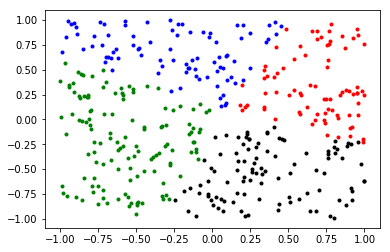

In [153]:
import matplotlib.pyplot as plt
for i in range(y.shape[0]):
    if index[i] == 0:
        plt.plot(x[i,0],x[i,1],'b.')
    elif index[i] == 1:
        plt.plot(x[i,0],x[i,1],'r.')
    elif index[i] == 2:
        plt.plot(x[i,0],x[i,1],'g.')
    else:
        plt.plot(x[i,0],x[i,1],'k.')
plt.show()